In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [3]:
df=pd.read_csv('training1.csv',nrows=100000)
df.head(3)


,id,qid1,qid2,question1,question2,is_duplicate,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,q1len,q2len,word_Common,word_Total,word_share,q1_n_words,q2_n_words
0,0,1,2,step step guide invest share market india,step step guide invest share market,0,100,93,93,98,41,35,5.0,11.0,0.454545,7,6
1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0,86,63,66,73,31,67,4.0,15.0,0.266667,5,10
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0,63,63,43,41,44,36,2.0,11.0,0.181818,6,5


In [4]:
X=df.drop(['is_duplicate','id'],axis=1)
X['Name'] = X['question1'].str.cat(X['question2'],sep=" ")
X=X.drop(['qid1','qid2','question1','question2'],axis=1)
y=df['is_duplicate']

In [5]:
X.head(5)

,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,q1len,q2len,word_Common,word_Total,word_share,q1_n_words,q2_n_words,Name
0,100,93,93,98,41,35,5.0,11.0,0.454545,7,6,step step guide invest share market india step...
1,86,63,66,73,31,67,4.0,15.0,0.266667,5,10,story kohinoor koh noor diamond would happen i...
2,63,63,43,41,44,36,2.0,11.0,0.181818,6,5,increase speed internet connection using vpn i...
3,28,24,9,20,21,44,0.0,9.0,0.000000,3,9,mentally lonely solve find remainder math 23 2...
4,67,47,35,54,60,29,2.0,15.0,0.133333,10,5,one dissolve water quikly sugar salt methane c...


Splitting the data into Train & Test

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=2020)
X_train.shape

(67000, 12)

# APPLYING TFIDF VECTORIZER

In [7]:
tfidf = TfidfVectorizer(ngram_range=(1,3),min_df=10)
tfidf.fit(X_train['Name'].values.astype('U'))
a=tfidf.transform(X_train['Name'].values.astype('U'))
d=tfidf.transform(X_test['Name'].values.astype('U'))

In [8]:
X_train=X_train.drop(['Name'],axis=1)
X_train.head()

,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,q1len,q2len,word_Common,word_Total,word_share,q1_n_words,q2_n_words
86282,85,85,92,90,13,13,2.0,4.0,0.500000,2,2
32452,81,38,35,78,41,18,2.0,9.0,0.222222,6,3
59758,28,28,18,39,12,36,0.0,8.0,0.000000,2,6
88731,60,48,46,47,38,59,3.0,14.0,0.214286,6,10
10731,63,63,47,56,21,24,1.0,6.0,0.166667,3,3


In [9]:
X_test=X_test.drop(['Name'],axis=1)
X_test.head()

,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,q1len,q2len,word_Common,word_Total,word_share,q1_n_words,q2_n_words
36082,88,88,88,81,18,18,3.0,6.0,0.500000,3,3
31787,66,64,68,70,42,33,2.0,10.0,0.200000,5,5
33964,88,71,64,76,30,19,3.0,7.0,0.428571,4,3
26097,43,45,47,51,41,27,1.0,8.0,0.125000,5,3
41101,62,57,54,62,31,46,2.0,10.0,0.200000,4,7


In [10]:
from scipy.sparse import hstack
X_train1=hstack((X_train.values,a)).tocsr()

In [11]:
X_test1=hstack((X_test.values,d)).tocsr()

# APPLYING LOGISTIC REGRESSION

In [12]:
from sklearn.metrics import plot_confusion_matrix,log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
alpha = [10 ** x for x in range(-5, 3)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train1, y_train)
    predict_y = sig_clf.predict_proba(X_test1)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))



For values of alpha =  1e-05 The log loss is: 0.48703180971845805
For values of alpha =  0.0001 The log loss is: 0.48458359058902745
For values of alpha =  0.001 The log loss is: 0.5199733591200434
For values of alpha =  0.01 The log loss is: 0.5521345034324899
For values of alpha =  0.1 The log loss is: 0.5602313853637287
For values of alpha =  1 The log loss is: 0.5842377196331484
For values of alpha =  10 The log loss is: 0.6029202086184602
For values of alpha =  100 The log loss is: 0.6142798593386


In [13]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train1, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                          

In [14]:
pred=sig_clf.predict(X_test1)

In [15]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)

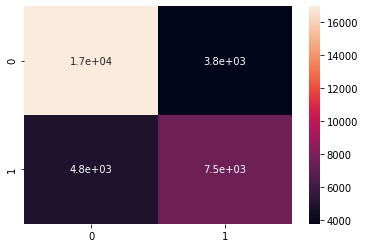

In [16]:
import seaborn as sns
sns.heatmap(cm,annot=True)

In [17]:
cm

array([[16938,  3764],
       [ 4829,  7469]], dtype=int64)

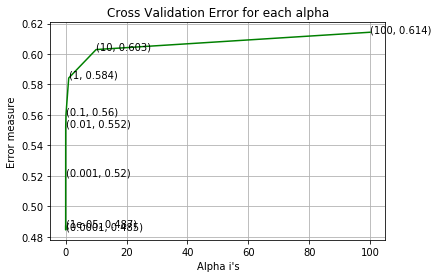

For values of best alpha =  0.0001 The train log loss is: 0.47822494554009154
For values of best alpha =  0.0001 The test log loss is: 0.48458359058902745
Total number of data points : 33000


In [18]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

predict_y = sig_clf.predict_proba(X_train1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

# APPLYING LINEAR SVM

For values of alpha =  1e-05 The log loss is: 0.4858488649882442
For values of alpha =  0.0001 The log loss is: 0.5104845506673207
For values of alpha =  0.001 The log loss is: 0.5579365099220095
For values of alpha =  0.01 The log loss is: 0.5618783244080942
For values of alpha =  0.1 The log loss is: 0.576574611163758
For values of alpha =  1 The log loss is: 0.6409278948026075
For values of alpha =  10 The log loss is: 0.6559165180352562
For values of alpha =  100 The log loss is: 0.6603597636362513
For values of alpha =  1000 The log loss is: 0.660359763636251


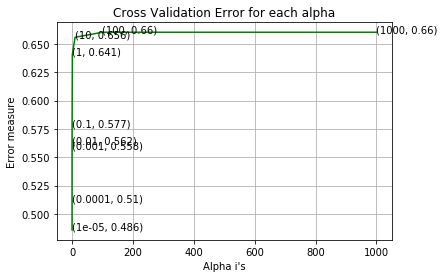

In [19]:
alpha = [10 ** x for x in range(-5, 4)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train1, y_train)
    predict_y = sig_clf.predict_proba(X_test1)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [20]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train1, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l1',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                         

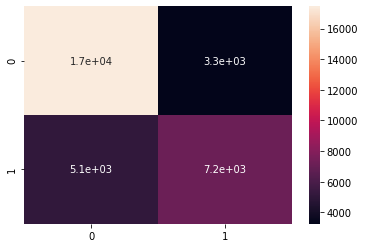

In [21]:
pred=sig_clf.predict(X_test1)
cm=confusion_matrix(y_test,pred)
sns.heatmap(cm,annot=True)

In [22]:
cm

array([[17451,  3251],
       [ 5134,  7164]], dtype=int64)

In [23]:
predict_y = sig_clf.predict_proba(X_train1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

For values of best alpha =  1e-05 The train log loss is: 0.4805248962145905
For values of best alpha =  1e-05 The test log loss is: 0.4858488649882442
Total number of data points : 33000


# XGBOOST

In [24]:
import xgboost as xgb

In [26]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {"max_depth":[1,5,10,50,75],
              "n_estimators":[50,100,200,300,400,500]}

model = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25), param_distributions=param_grid,n_iter=20,scoring='neg_log_loss',cv=3,n_jobs=-1)

model.fit(X_train1,y_train)
model.best_params_

{'n_estimators': 400, 'max_depth': 10}

In [27]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=25,max_depth=model.best_params_['max_depth'],n_estimators=model.best_params_['n_estimators'])
clf.fit(X_train1,y_train)
y_pred_test=clf.predict_proba(X_test1)
y_pred_train=clf.predict_proba(X_train1)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train,' Test log loss = ',log_loss_test)

Train log loss =  0.23778584994375798  Test log loss =  0.39180511397716733


In [2]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","vectorizer","log loss"]
x.add_row(['Logistic regression','TFIDF ','0.4845'])
x.add_row(['Linear SVM','TFIDF','0.4858'])
x.add_row(['XGBOOST','TFIDF ','0.3918'])

print(x)

+---------------------+------------+----------+
|        Model        | vectorizer | log loss |
+---------------------+------------+----------+
| Logistic regression |   TFIDF    |  0.4845  |
|      Linear SVM     |   TFIDF    |  0.4858  |
|       XGBOOST       |   TFIDF    |  0.3918  |
+---------------------+------------+----------+
